# Bolivian Musicians - Artist Segmentation

### Overview
Bolivian musicians are very talented but unfortunately not many people know it. This data-based project aims to promote bolivian artists and make them more visible for locals and the world.

The project consists in:
- The construction of a dataset of bolivian artists by fetching public Spotify data.

- The application of data clustering techniques to segment the collected data and gain
  artists description.
- The implementation of a web app for data visualization and knowledge-based artist recommendations.


### Problem Statement
After I searched in the web, I could not find a dataset of bolivian artists. Hence, I had to build one from scratch. As far as I know this is the first dataset of Bolivian artists. The details of the data collection are [here](https://github.com/leanguardia/bolivian-music#dataset-construction).

By nature music is very varied and artists are even more. Artists can be very diverse or stick to one genre of music. There are traditional, new, trending artists with different targeted listeners. For this matter, a number of unsupervised learning techniques are applied and evaluated to perform artists segmentation. The expected outcome is to gain deeper understanding of the data and use it the organize the knowledge recommendation system.

This notebook contains:
- Data Analysis
- Artist Clustering
- Result Evaluation
- Conclusions and Recommendations

### Metrics
- Number of Partitions: A number of partitions will be tested.
- Error Score: The configuration with less error score will be picked.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
%matplotlib inline

In [2]:
df = pd.read_csv('data/artists_flitered.csv')
df.shape

(204, 5)

In [3]:
df.head()

,artist_id,name,popularity,followers,genres
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97077,"['andean', 'charango', 'folklore boliviano']"
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47069,['hip hop boliviano']
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35314,"['cumbia boliviana', 'pop reggaeton']"
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27731,"['andean', 'folklore boliviano']"
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19783,"['andean', 'folklore boliviano']"


## Analysis
### Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist_id   204 non-null    object
 1   name        204 non-null    object
 2   popularity  204 non-null    int64 
 3   followers   204 non-null    int64 
 4   genres      204 non-null    object
dtypes: int64(2), object(3)
memory usage: 8.1+ KB


In [5]:
quantitative_cols = ['popularity', 'followers']
desc = df[quantitative_cols].describe()
desc

,popularity,followers
count,204.000000,204.000000
mean,18.215686,2923.656863
std,12.370812,8559.691106
min,0.000000,0.000000
25%,8.000000,204.750000
50%,17.000000,722.500000
75%,28.000000,2087.250000
max,56.000000,97077.000000


In [6]:
qualitative_cols = [col for col in df.columns if col not in quantitative_cols]
df[qualitative_cols].describe()

,artist_id,name,genres
count,204,204,204
unique,204,204,27
top,5cZuv449OspxPrjcVnLUrR,Pk2,[]
freq,1,1,36


#### Missing Values

In [7]:
df.isna().sum()

artist_id     0
name          0
popularity    0
followers     0
genres        0
dtype: int64

**Note:** Despite the first 4 columns not having any missing values. The `genre` column should be treated differently becuase it represents a list. Because there are stored as string, counting missing values should be treated differently:

In [8]:
no_genres = df[df.genres == '[]']
print(f"There are {no_genres.shape[0]} / {df.shape[0]} artists with no genres associated")

There are 36 / 204 artists with no genres associated


#### Duplicated values

In [9]:
# Duplicates by id or name.
df[df.duplicated('artist_id') | df.duplicated('name')]

,artist_id,name,popularity,followers,genres


**Note:** Duplicates were removed in data collection stage in `data/artists_eda` notebook.

### Data Visualization
#### Popularity

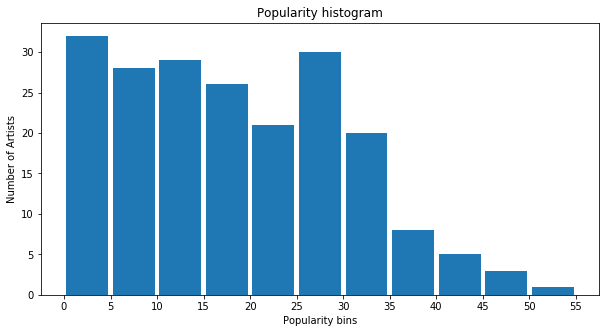

In [10]:
bins = np.arange(0, 60, 5)
ax = df.popularity.plot.hist(bins=bins, rwidth=0.9, figsize=(10,5));
ax.set_xlabel('Popularity bins'); ax.set_ylabel('Number of Artists'); 
ax.set_title('Popularity histogram')
plt.xticks(bins, bins);

Bimodal distribution skewed to the right. Half of the data has 17 points of popularity or less.

In [11]:
df.sort_values('popularity', ascending=False).head(10)

,artist_id,name,popularity,followers,genres
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97077,"['andean', 'charango', 'folklore boliviano']"
6,0SWtMcmZLgP04Kj5x0eCxa,azul azul,50,16351,['latin pop']
33,3U5KZkwiSmACysZTJIvjgU,Grupo Veneno,48,3676,['cumbia boliviana']
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47069,['hip hop boliviano']
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35314,"['cumbia boliviana', 'pop reggaeton']"
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27731,"['andean', 'folklore boliviano']"
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19783,"['andean', 'folklore boliviano']"
9,1pbcskpK1qePXm3sYvYu4o,Chila Jatun,42,14970,['andean']
8,1IYPsxunWpJvDYA1Por8dI,Diego Ríos,41,15293,['cumbia boliviana']
12,4EBLOxVwhNdq0BbTy0M6xN,Llajtaymanta,40,9818,"['andean', 'folklore boliviano', 'huayno']"


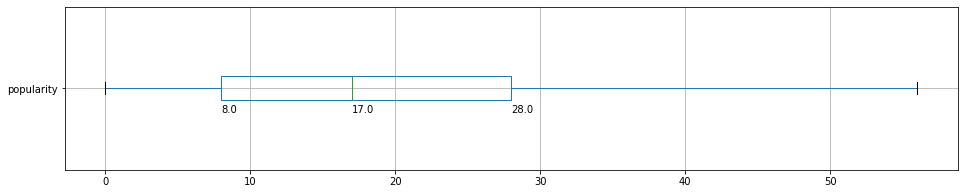

In [12]:
ax = df.boxplot(column='popularity', vert=False, figsize=(16,3));
ax.annotate(df.popularity.median(), (df.popularity.median(), 0.85))
ax.annotate(desc.popularity['25%'], (desc.popularity['25%'], 0.85))
ax.annotate(desc.popularity['75%'], (desc.popularity['75%'], 0.85));

No outliers found.

#### Followers

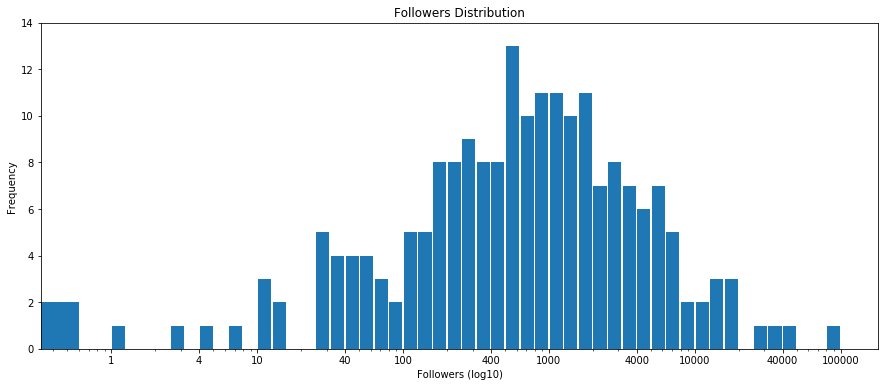

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.xscale('log')

positive_followers = df.followers[df.followers > 0]
no_followers = df[df.followers == 0].shape[0]
positive_followers_log = np.log10(positive_followers)

bin_edges = 10 ** np.arange(0, positive_followers_log.max()+0.1, 0.1)
ax.hist(positive_followers, bins=bin_edges, rwidth=0.90)
plt.bar(0.1, no_followers, width = 1)

xticks = [1,4,10, 40, 100, 400, 1000, 4000, 10000, 40000, 100000]
plt.xticks(xticks, xticks)
yticks = np.arange(0, 16, 2)
plt.yticks(yticks, yticks)
plt.title("Followers Distribution")
plt.ylabel("Frequency")
plt.xlabel("Followers (log10)");

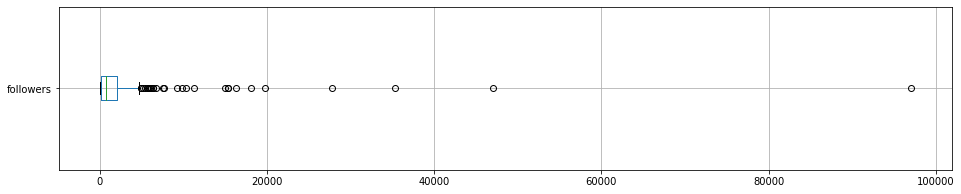

In [14]:
# Outliers
ax = df.boxplot(column='followers', vert=False, figsize=(16,3));

In [15]:
Q1 = desc.followers['25%']
Q3 = desc.followers['75%']
IQR = Q3 - Q1
followers_limit = Q3 + 1.5 * IQR

outliers = df[(df.followers >= followers_limit)]
print("Outliers:", outliers.shape[0], '/', df.shape[0], "elements with more than", followers_limit, 'followers.')
outliers.head()

Outliers: 28 / 204 elements with more than 4911.0 followers.


,artist_id,name,popularity,followers,genres
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97077,"['andean', 'charango', 'folklore boliviano']"
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47069,['hip hop boliviano']
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35314,"['cumbia boliviana', 'pop reggaeton']"
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27731,"['andean', 'folklore boliviano']"
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19783,"['andean', 'folklore boliviano']"


(176, 5)


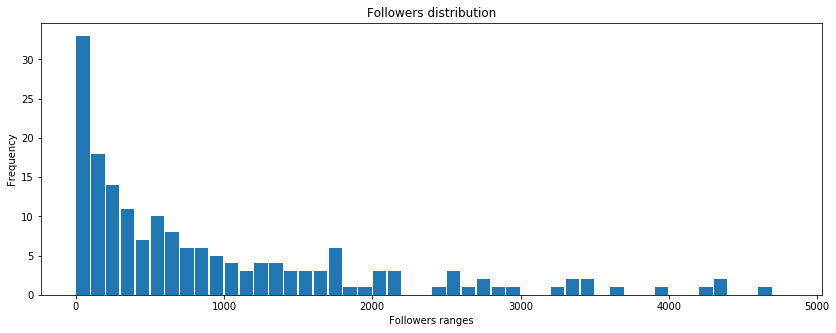

In [16]:
def remove_outliers(df):
    Q1 = df.followers.quantile(.25)
    Q3 = df.followers.quantile(.75)
    IQR = Q3 - Q1
    followers_limit = Q3 + 1.5 * IQR
    return df[df.followers <= followers_limit]
non_outliers = remove_outliers(df)
print(non_outliers.shape)
ax = non_outliers.followers.plot.hist(rwidth=0.9, bins=np.arange(0,4800+100,100), figsize=(14,5))
ax.set_title('Followers distribution'); ax.set_xlabel("Followers ranges");

#### Popularity and Followers

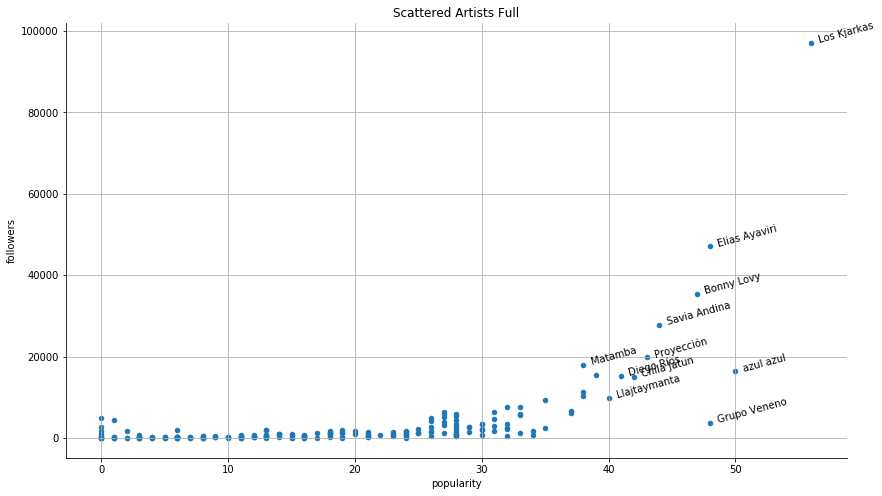

In [17]:
ax = df.plot.scatter(x='popularity', y='followers', figsize=(14,8))
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid()
popularity_thrs = 40
followers_thrs = 18000
top_artists = df[(df.popularity >= popularity_thrs) | (df.followers >= followers_thrs)]

for i, row in top_artists.iterrows():
    ax.annotate(row['name'], (row['popularity']+0.5, row['followers']), rotation=15)
ax.set_title("Scattered Artists Full");

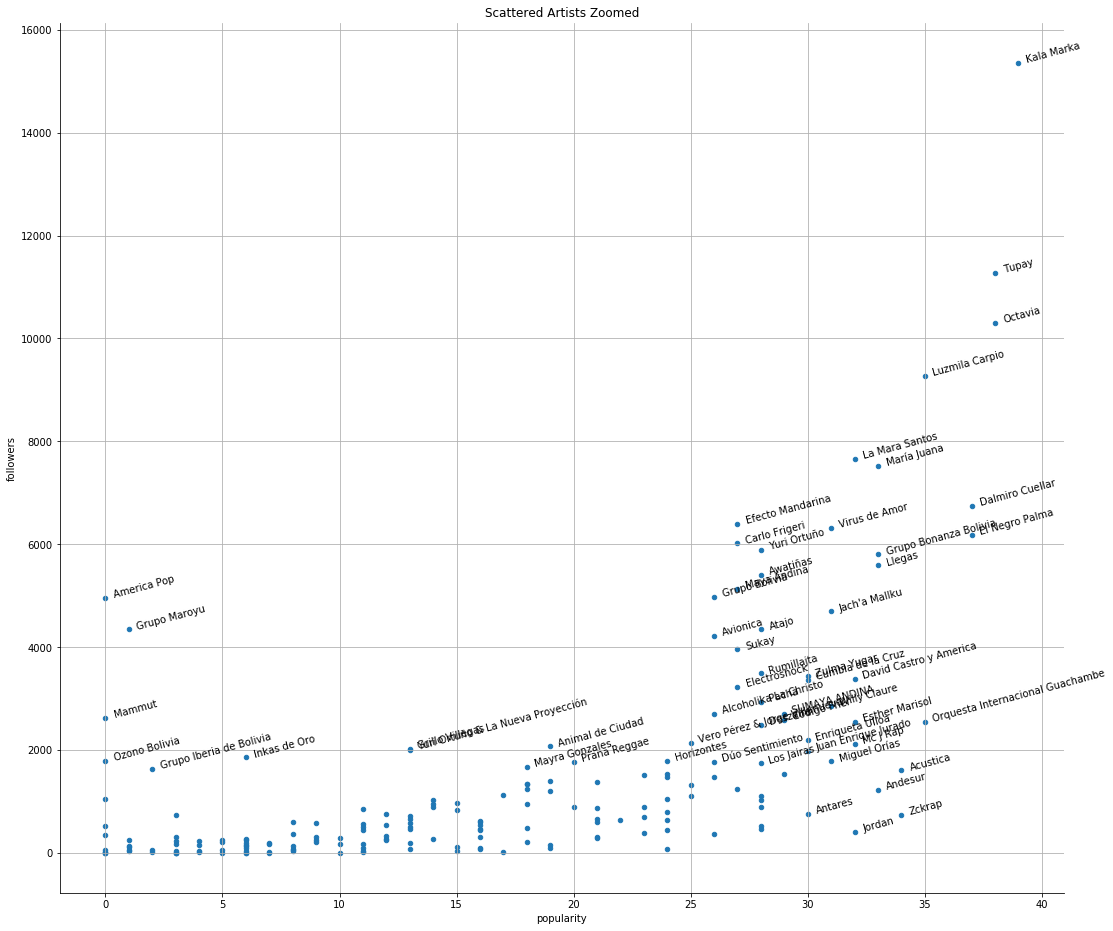

In [18]:
# Zoomed Plot
zoomed_artists = df[(df.popularity < popularity_thrs) & (df.followers < followers_thrs)]
ax = zoomed_artists.plot.scatter(x='popularity', y='followers', figsize=(18,16))
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid()
ax.set_title("Scattered Artists Zoomed 2X");

mid_artists = zoomed_artists[(zoomed_artists.popularity >= 30) | (zoomed_artists.followers >= 1600)]
for i, row in mid_artists.iterrows():
    ax.annotate(row['name'], (row['popularity']+0.3, row['followers']), rotation=15)
ax.set_title("Scattered Artists Zoomed");

#### Genres

Number of genres: 20


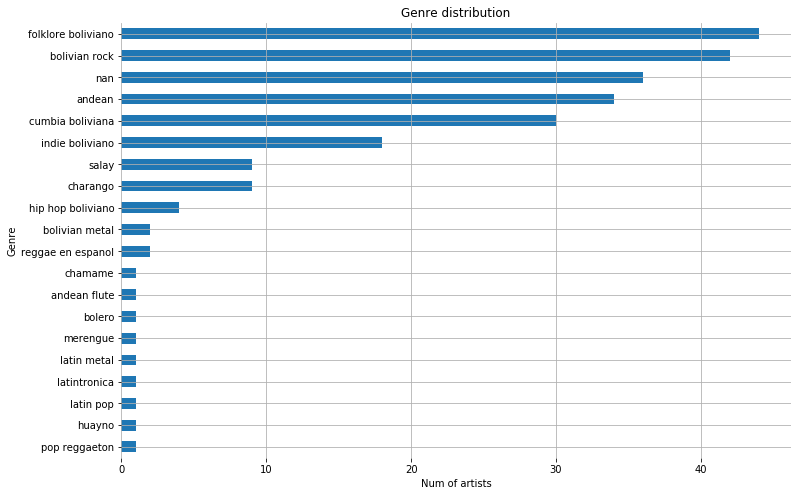

In [19]:
df.genres = df.genres.apply(literal_eval)
def plot_genre_dist(df):
    exploded = df.genres.explode()
    print("Number of genres:", len(exploded.unique()))
    ax = exploded.value_counts(dropna=False).sort_values(ascending=True).plot.barh(figsize=(12,8))
    ax.set_xlabel('Num of artists'); ax.set_ylabel('Genre'); ax.set_title('Genre distribution');
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid();
    ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False);
plot_genre_dist(df)

Number of genres: 22


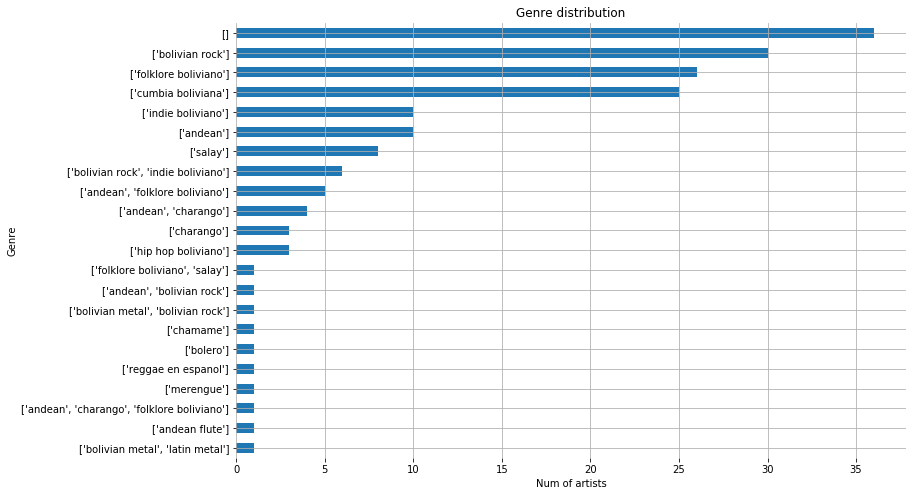

In [20]:
plot_genre_dist(non_outliers)

Removing outliers results in loosing 24 artists and 4 genres.

## Methodology

### Data Preprocessing

The `genres` column contains a list of genres. These will be split in dummy columns to represent wheter an artist is labeled with a genre `1` or not `0`.

In [21]:
genres = pd.Series(df.genres.explode().unique())
genres = genres.replace(np.nan, 'NaN').tolist()
genres

['andean',
 'charango',
 'folklore boliviano',
 'hip hop boliviano',
 'cumbia boliviana',
 'pop reggaeton',
 'bolivian rock',
 'reggae en espanol',
 'latin pop',
 'huayno',
 'latintronica',
 'indie boliviano',
 'bolivian metal',
 'salay',
 'bolero',
 'merengue',
 'andean flute',
 'chamame',
 'NaN',
 'latin metal']

**Note:** In this case it makes sense to include `NaN` values to the model. There might be artists which genre was not assigned by  Spotify for a specific reason. E.g. low popularity.

In [22]:
# Create a container to fill dummy variables
zeroes = np.zeros((df.shape[0], len(genres)))
dummies = pd.DataFrame(zeroes, columns=genres, index=df.index, dtype=int)

# Fill dummy variables for each genre in the list.
for i, artist_genres in enumerate(df.genres):
        indices = np.unique(dummies.columns.get_indexer(artist_genres))
        dummies.iloc[i, indices] = 1

# Merge dummies to df
df_model = pd.concat([df, dummies], axis=1)
df_model.head()

,artist_id,name,popularity,followers,genres,andean,charango,folklore boliviano,hip hop boliviano,cumbia boliviana,...,latintronica,indie boliviano,bolivian metal,salay,bolero,merengue,andean flute,chamame,NaN,latin metal
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97077,"[andean, charango, folklore boliviano]",1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47069,[hip hop boliviano],0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35314,"[cumbia boliviana, pop reggaeton]",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27731,"[andean, folklore boliviano]",1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19783,"[andean, folklore boliviano]",1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Implementation

In [23]:
from sklearn.cluster import KMeans
import numpy as np

def plot_clusters(dataframe, clusters):
    cluster_series = pd.Series(clusters, name="cluster", dtype=int, index=dataframe.index)
    df_clusters = pd.concat([dataframe, cluster_series], axis=1)
    k = len(pd.unique(clusters))
    fig, ax = plt.subplots(figsize=(12,7))
    sns.scatterplot(data=df_clusters, x='popularity', y='followers', hue='cluster', ax=ax, palette="tab20")

    ax.set_title("Artist Segmentation (k={})".format(k)); ax.set_xlabel('popularity')
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid();
    return df_clusters
    
def segment_data(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    clusters = kmeans.labels_
    return kmeans, clusters

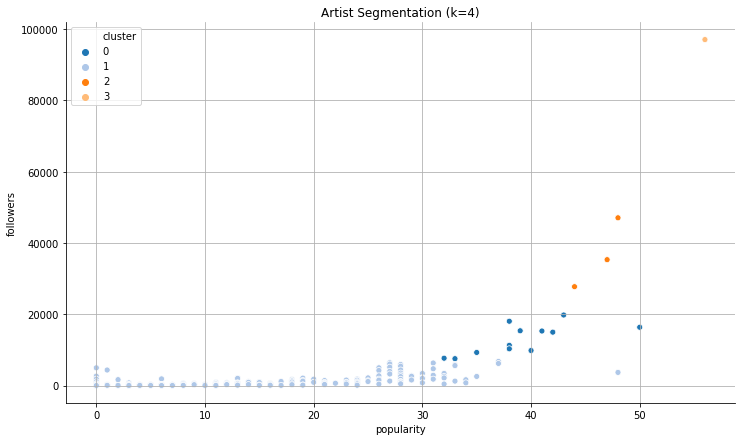

In [24]:
features = ['popularity', 'followers'] + genres
kmeans, clusters = segment_data(df_model[features], k=4)
_ = plot_clusters(df_model, clusters)

In [26]:
kmeans.cluster_centers_[:, :2]

array([[3.90833333e+01, 1.29711667e+04],
       [1.62340426e+01, 1.24245213e+03],
       [4.63333333e+01, 3.67046667e+04],
       [5.60000000e+01, 9.70770000e+04]])

**Note:** The Previous segmentation is manly using followers data since the features have not been scaled. `KMeans` uses Euclidean Distance to measure similarity between data poits, therefore, data needs to be scaled before fitting. (Data Engineering Lesson Nanodegree). 

#### Scaling Features

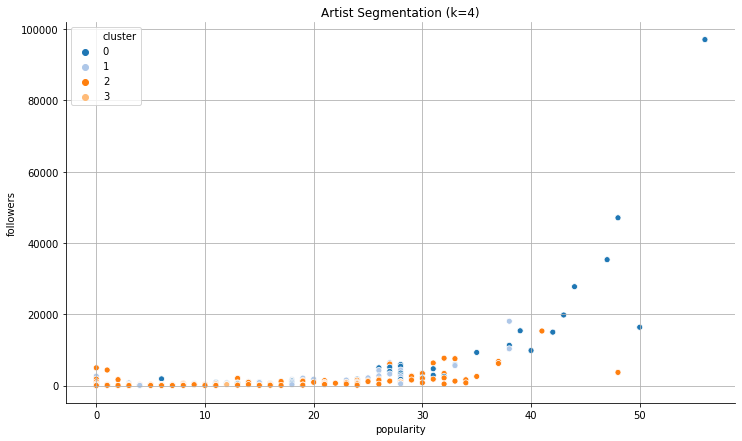

In [27]:
from sklearn.preprocessing import scale

df_model['popularity_std'] = scale(df_model.popularity)
df_model['followers_std'] = scale(df_model.followers)

genres_std = [genre + ' std' for genre in genres]
dummies_std = pd.DataFrame(scale(dummies), columns=genres_std)

df_model = pd.concat([df_model, dummies_std], axis=1)
features = ['popularity_std', 'followers_std'] + genres_std
kmeans, clusters = segment_data(df_model[features], k=4)
_ = plot_clusters(df_model, clusters)

Now, Kmeans found groups based in popularity, followers, 20 possible music genres, and one the absense of genre. Next, the correct number of clusters.


### Define the number of Clusters
#### Elbow Method

For a series of number clusters, find the smallest one with lower decrease of `wcss` (within cluster squared sums) in a the skree plot.

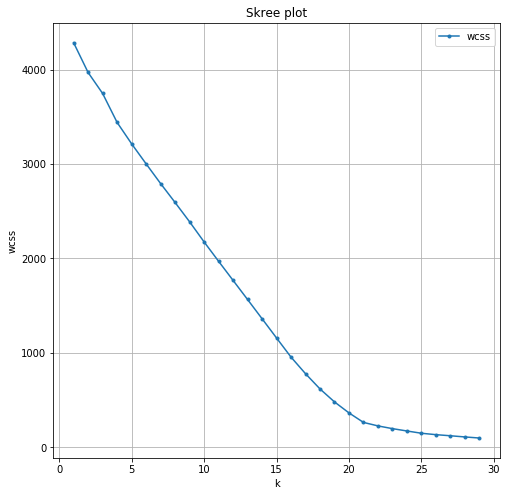

In [28]:
features = ['popularity_std', 'followers_std'] + genres_std
clusters_list = np.arange(1,30)
wcss = []
labels = []
X = df_model[features]

for k in clusters_list:
    kmeans, clusters = segment_data(X, k)
    wcss.append(kmeans.inertia_)
    labels.append(clusters)

def plot_skree(clusters_list, wcss):
    clusters_res = pd.DataFrame({'k': clusters_list, 'wcss': wcss})
    ax = clusters_res.plot(x='k', y='wcss', marker='.', figsize=(8,8))
    ax.set_title('Skree plot'); ax.set_ylabel('wcss'); plt.grid()
plot_skree(clusters_list, wcss)

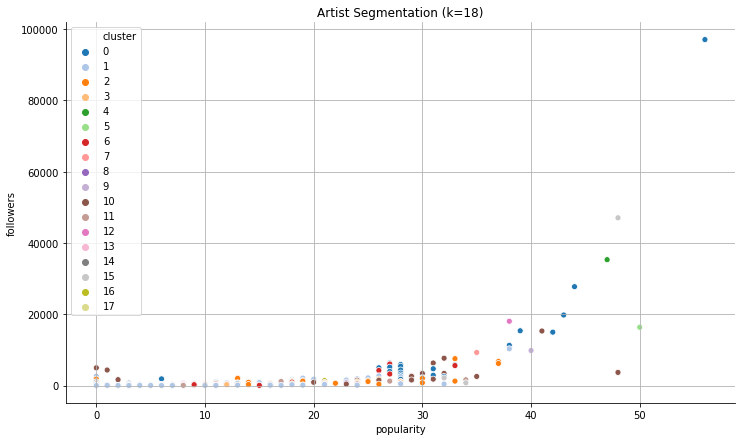

In [29]:
num_of_clusters = 18
clusters = labels[num_of_clusters-1]
_ = plot_clusters(df_model, clusters)

Since 18 clusters are too many groups. Elbow method is re-aplied for the subset without outliers.

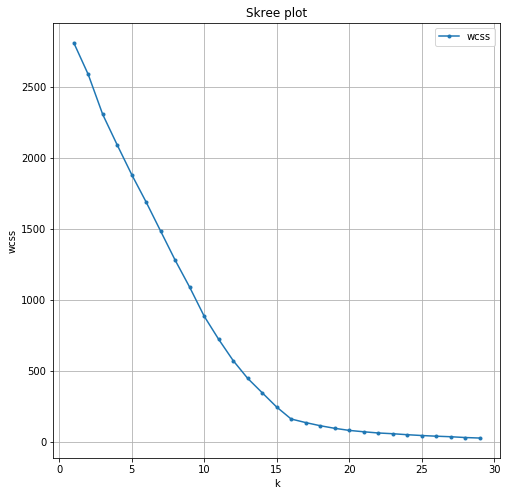

In [30]:
features = ['popularity_std', 'followers_std'] + genres_std
clusters_list = np.arange(1,30)
wcss = []
labels = []
non_outliers = remove_outliers(df_model)
X = non_outliers[features]

for k in clusters_list:
    kmeans, clusters = segment_data(X, k)
    wcss.append(kmeans.inertia_)
    labels.append(clusters)

plot_skree(clusters_list, wcss)

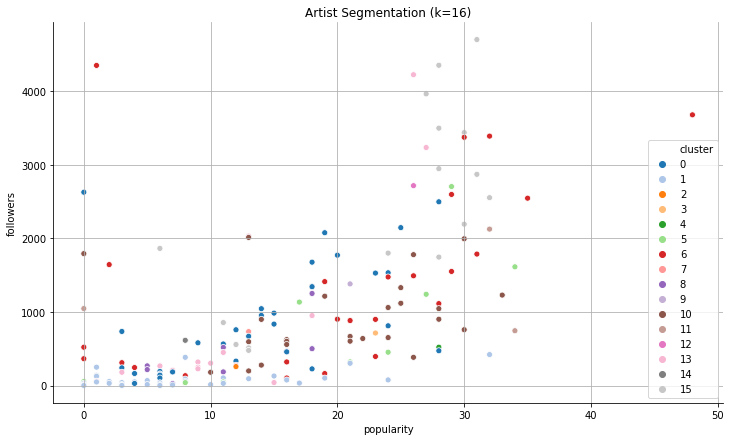

In [31]:
num_of_clusters = 16
clusters = labels[num_of_clusters-1]
df_clusters = plot_clusters(non_outliers, clusters)

In [32]:
df_clusters

,artist_id,name,popularity,followers,genres,andean,charango,folklore boliviano,hip hop boliviano,cumbia boliviana,...,indie boliviano std,bolivian metal std,salay std,bolero std,merengue std,andean flute std,chamame std,NaN std,latin metal std,cluster
28,6yVxbzScbih8Uvyfrdhx17,Jach'a Mallku,31,4698,[andean],1,0,0,0,0,...,-0.311086,-0.099504,-0.214834,-0.070186,-0.070186,-0.070186,-0.070186,0.0,-0.070186,15
29,1CIQKMq8233RjSs4VMk0a9,Atajo,28,4349,"[andean, bolivian rock]",1,0,0,0,0,...,-0.311086,-0.099504,-0.214834,-0.070186,-0.070186,-0.070186,-0.070186,0.0,-0.070186,15
30,7gs6RrJmRq75GL9PYwCX0L,Grupo Maroyu,1,4347,[cumbia boliviana],0,0,0,0,1,...,-0.311086,-0.099504,-0.214834,-0.070186,-0.070186,-0.070186,-0.070186,0.0,-0.070186,6
31,1kqcnt8DXUkuuRnawXGS38,Avionica,26,4221,"[bolivian rock, indie boliviano]",0,0,0,0,0,...,3.214550,-0.099504,-0.214834,-0.070186,-0.070186,-0.070186,-0.070186,0.0,-0.070186,13
32,45MEz7t5DAOmX0o8fFKA3B,Sukay,27,3961,[andean],1,0,0,0,0,...,-0.311086,-0.099504,-0.214834,-0.070186,-0.070186,-0.070186,-0.070186,0.0,-0.070186,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,7rsWpmBlaDWndspQrhyMkC,Magoman,0,5,[],0,0,0,0,0,...,-0.311086,-0.099504,-0.214834,-0.070186,-0.070186,-0.070186,-0.070186,0.0,-0.070186,1
200,0PuGi5xDkkBSp0VxPqAdwJ,Rodrigo Mc,3,3,[],0,0,0,0,0,...,-0.311086,-0.099504,-0.214834,-0.070186,-0.070186,-0.070186,-0.070186,0.0,-0.070186,1
201,7b4FiXD70tUTy79EYPNgwP,Juan Manuel Thorrez,3,1,[],0,0,0,0,0,...,-0.311086,-0.099504,-0.214834,-0.070186,-0.070186,-0.070186,-0.070186,0.0,-0.070186,1
202,1S6elt0a8pmo996HL2y9Gz,Gaston Sosa,0,0,[],0,0,0,0,0,...,-0.311086,-0.099504,-0.214834,-0.070186,-0.070186,-0.070186,-0.070186,0.0,-0.070186,1


### Refinement

## Results

### Model Evaluation

### Justification

## Conclusion
### Reflection
### Improvement
